In [1]:
import pandas as pd
import numpy as np

In [3]:
stock = pd.read_csv('HPG Historical Data.csv')
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values(by='Date')
stock = stock.set_index('Date')
stock['Price'] = stock['Price'].str.replace(',', '').astype(float)
stock['Open'] = stock['Open'].str.replace(',', '').astype(float)
stock['High'] = stock['High'].str.replace(',', '').astype(float)
stock['Low'] = stock['Low'].str.replace(',', '').astype(float)
stock['Vol.'] = stock['Vol.'].str.replace('M', '').astype(float)
stock['Change %'] = stock['Change %'].str.replace('%', '').astype(float)


In [10]:
r_t = np.log(stock['Price'] / stock['Price'].shift(1)).dropna()
r_t = r_t.values



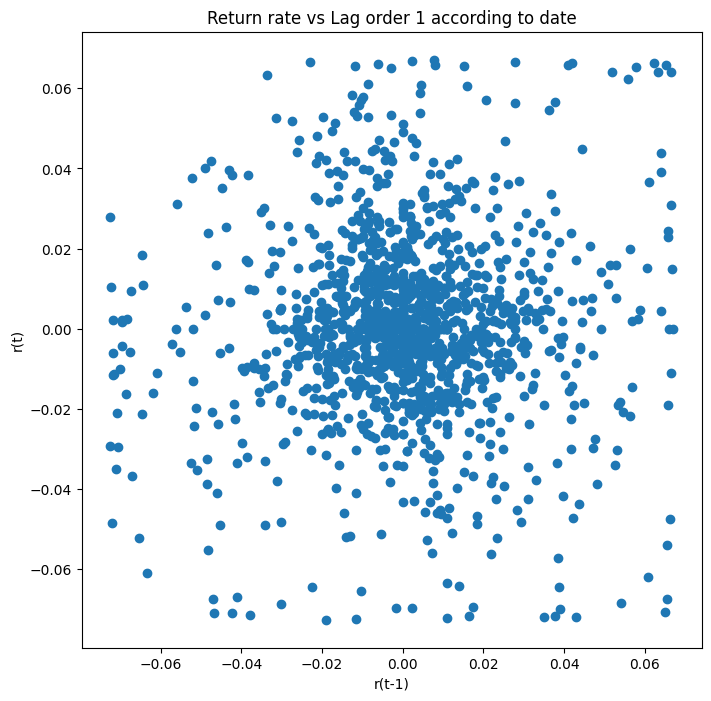

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

/tmp/ipykernel_1383/2568514480.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(r_t, bins=100, kde=False)


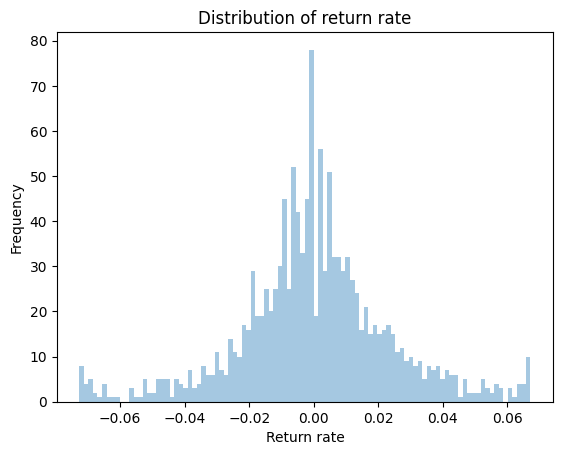

In [12]:
import seaborn as sns
# plot distribution of return rate
mean = np.mean(r_t)
std = np.std(r_t)
sns.distplot(r_t, bins=100, kde=False)
plt.title('Distribution of return rate')
plt.xlabel('Return rate')
plt.ylabel('Frequency')
plt.show()

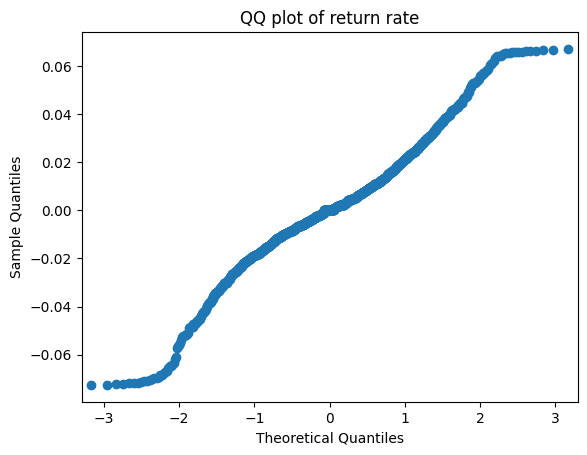

In [14]:
import statsmodels.api as sm
sm.qqplot(r_t)
plt.title('QQ plot of return rate')
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -34.838689
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


P<0.05 reject the H0 hypothesis 

<Figure size 800x600 with 0 Axes>

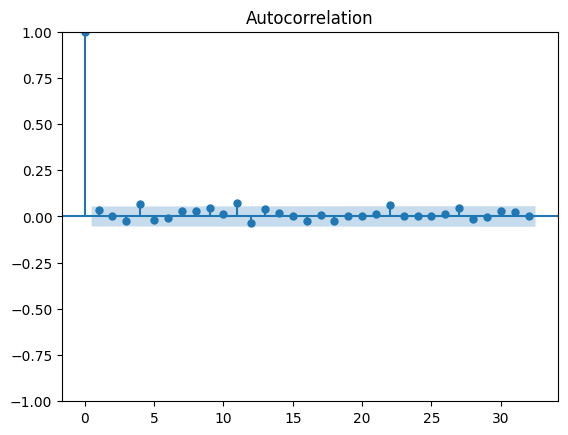

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(8, 6))
ax1 = plot_acf(r_t)


<Figure size 800x600 with 0 Axes>

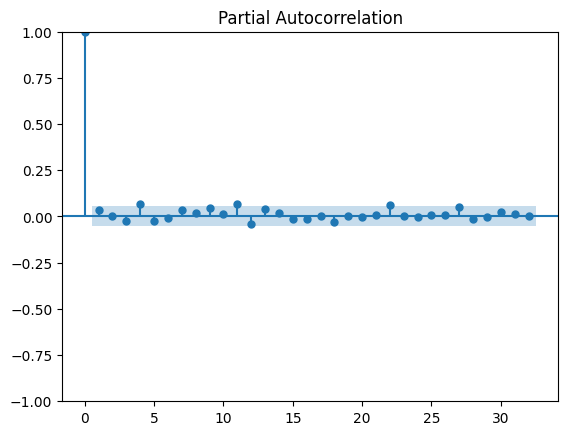

In [17]:
plt.figure(figsize=(8, 6))
ax2 = plot_pacf(r_t)

In [69]:
# find the date at the index 1057
# stock.index[1035]

print(len(r_t))
print(len(stock.index))
# Check if r_t have null value


1307
1308


In [65]:
from statsmodels.tsa.arima.model import ARIMA
orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5)]
#compare different orders of ARIMA model aiming to find the best one
# The train data from January 2 2018 to February 28 2022 
# The test data from March 1 2022 to March 31 2023
train = r_t[:1035]
test = r_t[1035:]
best_aic = np.inf
best_order = None
for order in orders:
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_order = order
print('Best order:', best_order)


    

Best order: (0, 0, 5)


In [82]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()
r_t_pred = model_fit.predict(start=1035, end=1310)


# Given r_t = np.log(stock['Price'] / stock['Price'].shift(1)) and r_t_pred ,
# we can calculate the predicted price of stock by reverse the formula

#Create a loop to calculate the predicted price of stock from March 1 2022 to March 31 2023
stock['Price_pred'] = np.nan
for i in range(1035, 1040):
    stock['Price_pred'][i-1035] = stock['Price'][i] * np.exp(r_t_pred[i-1035])
    stock['Price'] = stock['Price'].shift(-1)
    stock['Price_pred'] = stock['Price_pred'].shift(-1)
# Is there a faster way to calculate the predicted price from March 1 2022 to March 31 2023 other than using loop?











/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

KeyError: 0

In [58]:
print(len(price_pred))

276


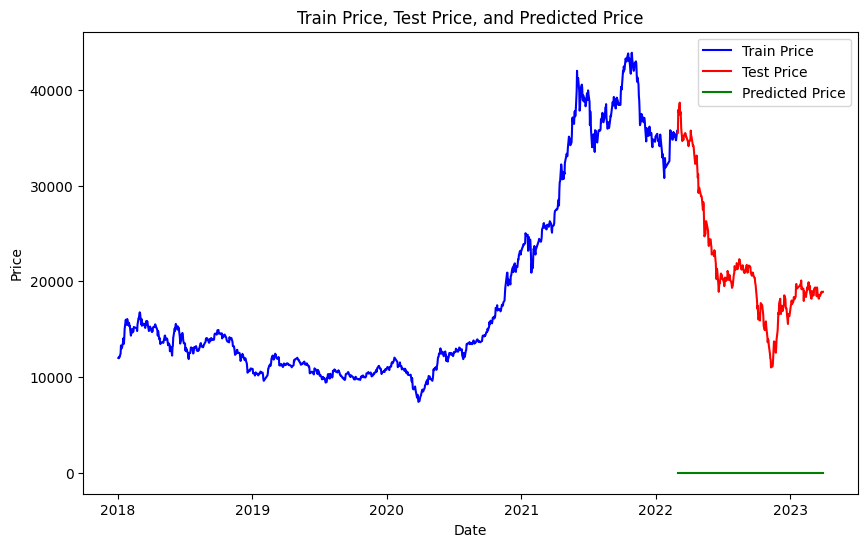

In [77]:
# turn the data back into the original scale and fit the best Arima model



#Plot the train price from January 2 2018 to February 28 2022 , test price and the predicted price
# the predicted price for the period from March 1 2022 to March 31 2023
plt.figure(figsize=(10, 6))
plt.plot(stock.index[:1035], stock['Price'][:1035], label='Train Price',color='blue')
plt.plot(stock.index[1035:], stock['Price'][1035:], label='Test Price',color='red')
plt.plot(stock.index[1035:], price_pred[0:273], label='Predicted Price',color='green')
plt.title('Train Price, Test Price, and Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [4]:
#Dickey-Fuller test. The null hypothesis of the test is that the time series is not stationary.
from statsmodels.tsa.stattools import adfuller
result = adfuller(stock['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# The p-value is greater than 0.05, so we cannot reject the null hypothesis that the time series is not stationary.
# We need to difference the time series to make it stationary.
stock['Price Difference'] = stock['Price'] - stock['Price'].shift(1)
result = adfuller(stock['Price Difference'].dropna())
print('ADF Statistic: %f' % result[0])  
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# The p-value is less than 0.05, so we can reject the null hypothesis that the time series is not stationary.



ADF Statistic: -1.186168
p-value: 0.679518
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF Statistic: -7.711239
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


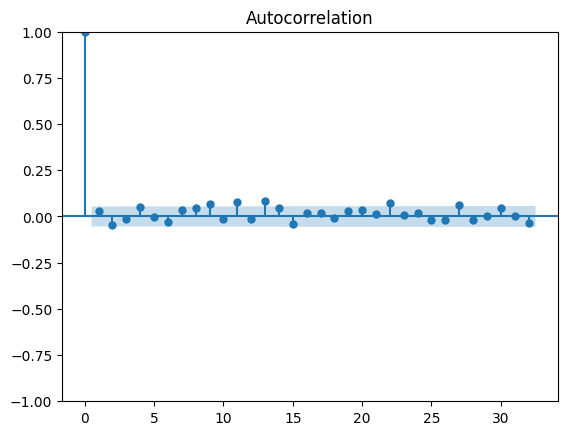

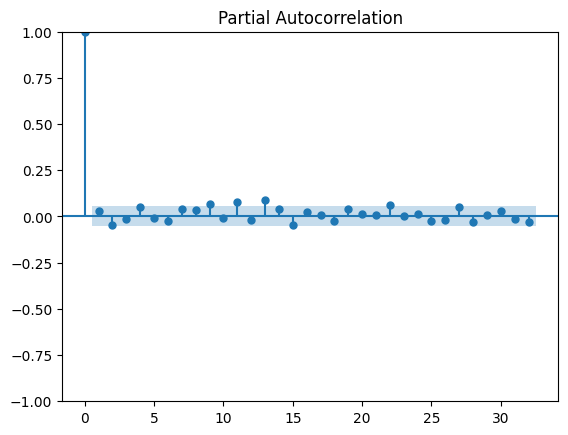

In [8]:
#using Plot the ACF and PACF charts and find the optimal parameters for the ARIMA model.
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(stock['Price Difference'].dropna())
plot_pacf(stock['Price Difference'].dropna())
plt.show()

# The ACF chart shows a significant spike at lag 1, so we should use p=1.
# The PACF chart shows a significant spike at lag 1, so we should use q=1.
# The d=1 because we differenced the time series once to make it stationary.




/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

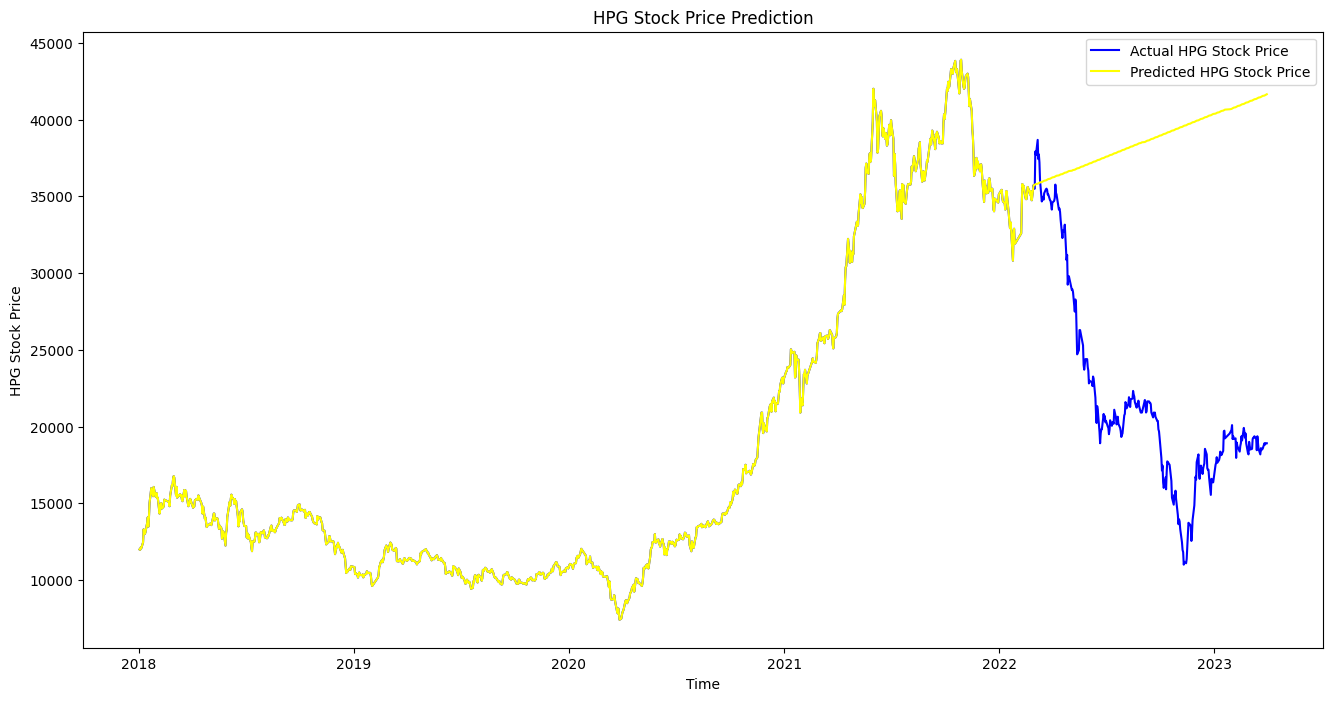

In [7]:
# Fit the ARIMA model to the stationary time series.
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(stock['Price difference '], order=(1,1,1))



In [24]:
print(model_fit.params)

ar.L1         -0.884893
ma.L1          0.915995
sigma2    209086.732132
dtype: float64
